In [1]:
import numpy as np

In [2]:
collision = np.load('.data/Time_series_colisao.npz')
display(collision.keys())
spreading = np.load('.data/Time_series_espalhamento.npz')
display(spreading.keys())

KeysView(NpzFile '.data/Time_series_colisao.npz' with keys: TS, Re, We, B)

KeysView(NpzFile '.data/Time_series_espalhamento.npz' with keys: TS, Re, We, Fr, V0...)

# Colisão | Collision

In [3]:
collision_timesteps_raw = collision['TS']
display(collision_timesteps_raw.shape)

(72, 1000, 5)

In [4]:
components: list[dict] = list()
for cmpnt in range(5):
    components.append({
        "original": collision_timesteps_raw[:, :, cmpnt].T
    })

In [5]:
from typing import Literal
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer


chosen_scaler: Literal[
    'StandardScaler',
    'MinMaxScaler',
    'RobustScaler',
    'MaxAbsScaler',
    'QuantileTransformer',
    'PowerTransformer',
    'Normalizer'
] = 'MaxAbsScaler'
for component_dict in components:
    component_dict["scaler"] = eval(chosen_scaler)()
    component_dict["scaled"] = component_dict["scaler"].fit_transform(component_dict["original"])

In [6]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from uuid import uuid4

def generate_autoencoder():
    input = Input(shape=(72,))
    hidden_1 = Dense(27, activation='linear')(input)
    encoding_dim = Dense(9, activation='linear')(hidden_1)
    hidden_2 = Dense(27, activation='linear')(encoding_dim)
    output = Dense(72, activation='linear')(hidden_2)
    model = Model(input, output)
    optim = Adam(learning_rate=0.1)
    model.compile(
        optimizer=optim,
        loss='mean_absolute_percentage_error',
        metrics=[
            mean_squared_error,
            mean_absolute_percentage_error
        ])
    return model


def scheduler(epoch, lr):
    power = - 0.04 * epoch
    if epoch < 100:
        return 0.1 * np.e ** power
    else:
        return 0.001


def train_autoencoder(autoencoder, data):    
    lr_scheduler = LearningRateScheduler(schedule=scheduler)
    model_uuid = uuid4()
    checkpoint = ModelCheckpoint(filepath=f"/tmp/{model_uuid}/model.weights.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True)
    history = autoencoder.fit(
        data, data,
        batch_size = 15,
        epochs=150,
        verbose=True,
        shuffle=True,
        callbacks=[
            lr_scheduler,
            checkpoint
        ]
    )
    return history

2024-04-03 13:55:10.621746: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 13:55:10.660967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 13:55:11.548256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
permutation_idx = np.random.permutation(collision_timesteps_raw.shape[1])
for component in components:
    component["model"] = generate_autoencoder()
    component["training_data"] = component["scaled"][permutation_idx[:666]]
    component["training_history"] = train_autoencoder(component["model"], component["training_data"])

Epoch 1/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - loss: 120.0492 - mean_absolute_percentage_error: 120.0492 - mean_squared_error: 0.8943
Epoch 1: loss improved from inf to 336.34860, saving model to /tmp/ff935866-6b44-4a68-b9d7-86e917cc9f39/model.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 590.2518 - mean_absolute_percentage_error: 590.4000 - mean_squared_error: 50.7627 - learning_rate: 0.1000
Epoch 2/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 59.5585 - mean_absolute_percentage_error: 59.5585 - mean_squared_error: 0.2084
Epoch 2: loss improved from 336.34860 to 22.86734, saving model to /tmp/ff935866-6b44-4a68-b9d7-86e917cc9f39/model.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32.1258 - mean_absolute_percentage_error: 32.1314 - mean_squared_error: 0.0736 - learning_rate: 0.0961
Epoch 3/150
 1/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 18.3254 - mean_absolute_percentage_error: 18.3254 - mean_squared_error: 0.0147
Epoch 3: loss improved from 22.8

In [8]:
# testing
for component in components:
    component["testing_data_scaled"] = component["scaled"][permutation_idx[666:]]
    component["prediction_scaled"] = component["model"].predict(component["testing_data_scaled"])
    component["testing_data_unscaled"] = component["scaler"].inverse_transform(component["testing_data_scaled"])
    component["prediction_unscaled"] = component["scaler"].inverse_transform(component["prediction_scaled"])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [9]:
import pandas as pd

pd.set_option('display.float_format', '{:.4f}'.format)

columns = pd.MultiIndex.from_product([['MSE', 'MAPE'], ['min', 'max', 'mean']])
data = np.zeros((5, 6))
result_df = pd.DataFrame(
    data,
    index=pd.RangeIndex(0, 5, name="Component"),
    columns=columns
)

for cmpnt, component in enumerate(components):
    component["mse_loss"] = mean_squared_error(component["testing_data_unscaled"], component["prediction_unscaled"])
    component["mape_loss"] = mean_absolute_percentage_error(component["testing_data_unscaled"], component["prediction_unscaled"])
    result_df.loc[cmpnt, ("MSE", "min")] = np.min(component["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "max")] = np.max(component["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "mean")] = np.mean(component["mse_loss"])
    result_df.loc[cmpnt, ("MAPE", "min")] = np.min(component["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "max")] = np.max(component["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "mean")] = np.mean(component["mape_loss"])

display("Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente")
display(result_df)

'Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente'

MSE                      MAPE                  
             min       max     mean    min       max    mean
Component                                                   
0         0.0001    0.0065   0.0032 0.6593    4.3341  2.6734
1         0.0001    0.0218   0.0042 0.2975    5.9841  2.3645
2         0.5578 7485.1387 164.0656 4.4577   20.8888  8.9510
3         6.2586  511.3791  71.6406 0.3852    2.2015  0.7892
4         1.4657  336.3635  35.8600 0.1355 5871.2812 17.9948

In [10]:
import pandas as pd

pd.set_option("display.float_format", '{:.4f}'.format)

components_idx = pd.Index(["Diâmetro", "Altura", "Energia Cinética", "Energia Superficial", "Energia Dissipativa"], name="Componente")
snapshots_idx = pd.Index(permutation_idx[666:], name="Snapshot")
columns = ["MSE", "MAPE"]
data = np.zeros((5 * 334, 2))

index = pd.MultiIndex.from_product([components_idx, snapshots_idx])
detailed_result_df = pd.DataFrame(
    data,
    index=index,
    columns=columns
)

for cmpnt, component in enumerate(components):
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MSE"] = np.array(component["mse_loss"])
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MAPE"] = np.array(component["mape_loss"])

display("Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente")
display(detailed_result_df)

'Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente'

MSE   MAPE
Componente          Snapshot              
Diâmetro            597      0.0034 2.9500
                    936      0.0029 2.9423
                    880      0.0044 3.6724
                    920      0.0034 3.3203
                    298      0.0035 2.5471
...                             ...    ...
Energia Dissipativa 845      1.7353 0.1453
                    902      1.8410 0.1496
                    611      2.0217 0.1471
                    470      4.0334 0.2759
                    659      1.9779 0.1748

[1670 rows x 2 columns]

/tmp/ipykernel_118071/2284941597.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_general.show()
/tmp/ipykernel_118071/2284941597.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_subs.show()


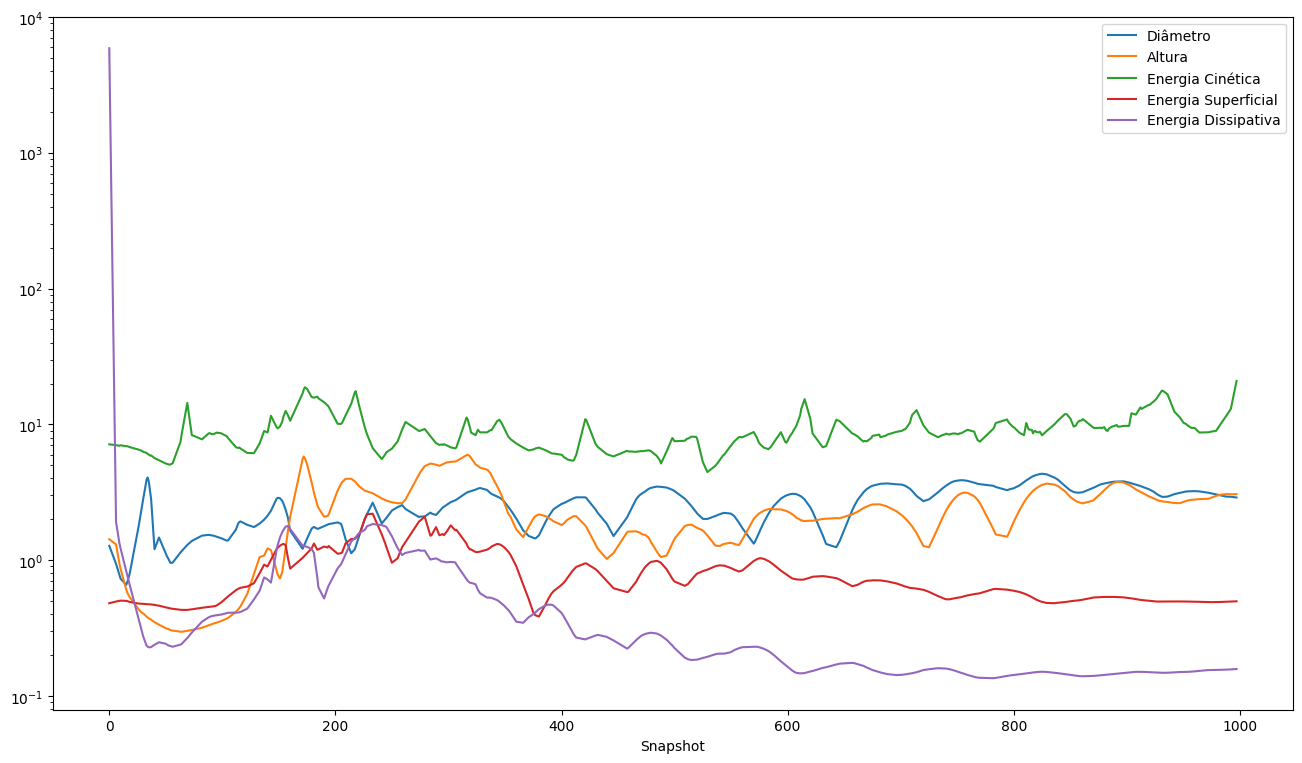

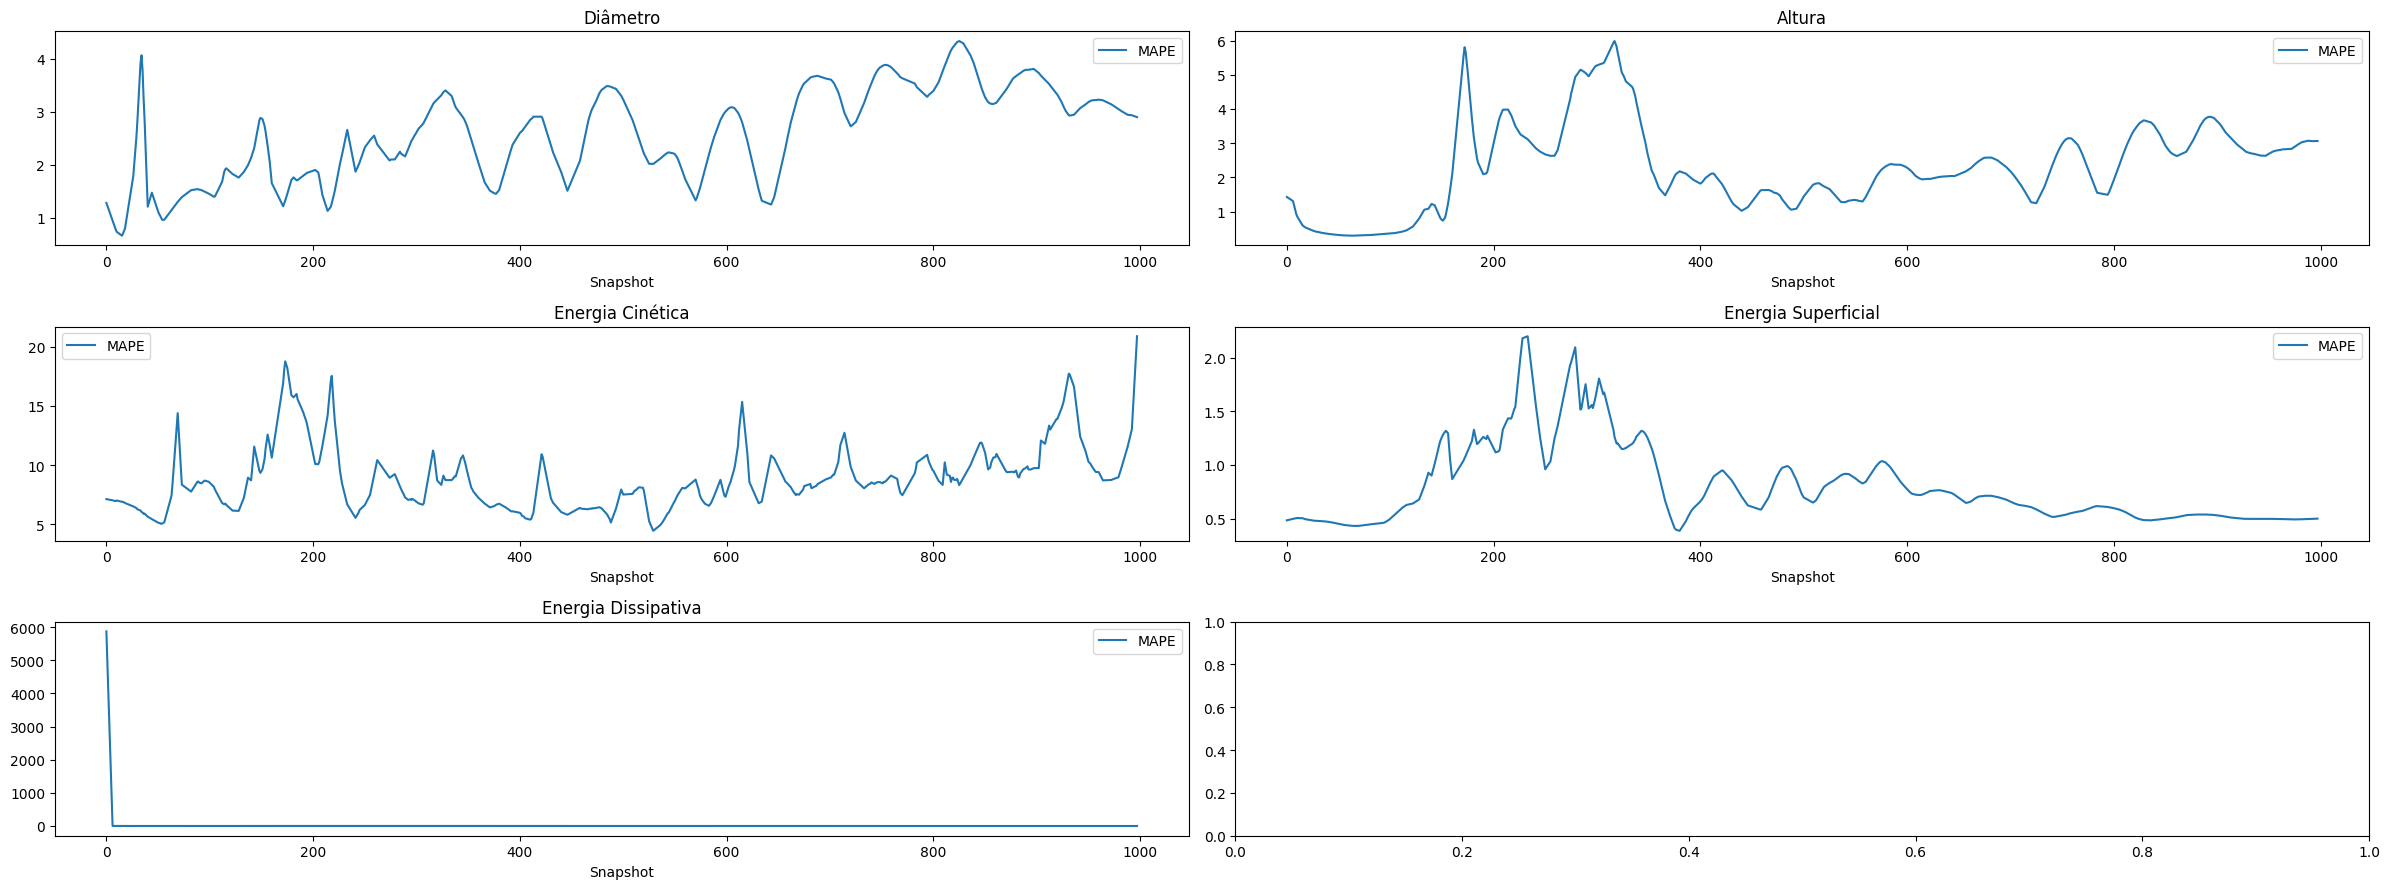

In [11]:
import matplotlib.pyplot as plt

fig_general, ax_general = plt.subplots(figsize=(16,9))
ax_general.set_yscale("log")

fig_subs, ax_subs = plt.subplots(3, 2, figsize=(24,9))

for k, cmpnt in enumerate(components_idx):
    i = k // 2
    j = k % 2
    detailed_result_df.loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_general, label=cmpnt)
    detailed_result_df.loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_subs[i, j])
    ax_subs[i, j].set_title(cmpnt)
    ax_subs[i, j].legend()
ax_general.legend()
fig_general.show()
fig_subs.tight_layout()
fig_subs.show()

##### Demonstrating that this transpose makes sense

In [12]:
# Let's test if this is correct
# Suppose we have tree simulations with 2 components each
# We have 3 timesteps
# First component is linear, second is quadratic
# First simulation starts with 1
# Second simulation starts with 2
# Third simulation starts with 3
# Therefore, first simulation first component is [1, 2, 3]
# Second simulation first component is [2, 3, 4]
# Third simulation first component is [3, 4, 5]
# First simulation second component is [1, 4, 9]
# Second simulation second component is [4, 9, 16]
# Third simulation second component is [9, 16, 25]
# Therefore, first timestep is [[1, 2, 3], [1, 4, 9]]
first_simulation = np.array([[1, 1], [2, 4], [3, 9]])
second_simulation = np.array([[2, 4], [3, 9], [4, 16]])
third_simulation = np.array([[3, 9], [4, 16], [5, 25]])
timesteps = np.array([first_simulation, second_simulation, third_simulation])
shape = timesteps.shape
display(shape)
transformed_timesteps = timesteps.transpose(1, 0, 2).reshape(shape[1], shape[0] * shape[2])
display(transformed_timesteps)

(3, 3, 2)

array([[ 1,  1,  2,  4,  3,  9],
       [ 2,  4,  3,  9,  4, 16],
       [ 3,  9,  4, 16,  5, 25]])